In [1]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')

import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
import scipy.stats as stats
from scipy import interp
from itertools import cycle

from utils.smart_utils import get_dir_path, tensor_to_pandas, load_hdf5_file
from utils.smart_utils import get_array_filenames, split_on_classes, create_row_mask
from utils.smart_utils import FuturoCube, calc_cos_sim, get_other_label
from preprocessing.process_data import get_data

from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score
from skfeature.function.similarity_based import reliefF

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.manifold import TSNE
from collections import OrderedDict

%matplotlib inline
%load_ext autoreload
%autoreload 2

PLOT_OUTPUT_DIR = '/home/jogi/git/repository/smart_play_set/plots/'

In [2]:
"""
    (1) Two-Sample T-Test: stats.ttest_ind
    (2) Paired T-Test (difference within the same group at different times)
                    stats.ttest_rel(a = before, b = after)
"""
def compute_t_test(X, y, feature_idxs, features, class_labels=[0,1]):
    
    # assuming binary classes
    normal = y == class_labels[0]
    positive = y == class_labels[1]
    print("")
    print("==================== Two sample T-test between classes %d <-> %d ==================" % 
          (class_labels[0], class_labels[1]))
    print("Normal/Positive ", np.count_nonzero(normal), np.count_nonzero(positive))
    
    for f in feature_idxs:
        n_group = X[normal, f]
        p_group = X[positive, f]

        t_value, p_value = stats.ttest_ind(a=n_group, b=p_group, equal_var=False)    
        # print("Feature %s: t_value %.4f, p_value %.4f, mean-normal %.3f, mean-positive %.3f" % 
        #     (features[f], t_value, p_value, np.mean(n_group), np.mean(p_group)))
        print("Feature %s: p_value %.4f (%.3f/%.3f)" % (features[f], p_value, np.mean(n_group), np.mean(p_group)))

# y_labels = y_labels_2c[:]
# compute_t_test(x_train_all, y_labels, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], features)

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          outfile=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from matplotlib import rcParams
    rcParams.update({'figure.autolayout': True})
    
    plt.figure(figsize=(8,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if outfile is not None:
        print("Save to %s" % outfile)
        plt.savefig(outfile, dpi=100)

    plt.show()

def create_level_sets(X, skill_labels, id_labels, level_labels):
    
    unique_levels = np.unique(level_labels)
    print("INFO -- create_level_sets ", unique_levels)
    datasets = {}
    for l in unique_levels:
        rows = np.where(level_labels==l)[0]
        x_data = X[rows]
        y_data = skill_labels[rows]
        y_ids = id_labels[rows]
        y_levels = level_labels[rows]
        datasets[l] = (x_data, y_data, y_ids, y_levels)
    
    return datasets
    
def get_features(mask, features):

    for i, f in enumerate(mask):
        print("%d. %s" % (i+1, features[f]))

        
def transform_x(X, features_idx):
    
    X_new = np.zeros((X.shape[0], len(features_idx)))
    for i, idx in enumerate(features_idx):
        X_new[:, i] = X[:, idx]
        
    return X_new


def prepare_data(option=330, two_class_opt='2_and_1'):
    
    if option == 330:   # 30 seconds window
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_330_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    elif option == 275:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_275_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)

    elif option == 990: # 10 seconds window
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_990_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    elif option == 1980:  # 5 seconds window
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_1980_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
        
    elif option == 3960:  # 5 seconds with 0.5 overlapping
        
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_3960_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    else:
        raise NotImplementedError("Error, %s as option is not implemented" % str(option))

    features = dta_dict_f['features']

    y_labels_all = np.squeeze(y_labels_all)
    y_labels_2c = np.zeros(y_labels_all.shape[0], dtype=np.int)
    y_labels_2c[:] = y_labels_all[:]
    if two_class_opt == 'merge_1_2':
        # merge group 1 and 2
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
    elif two_class_opt == 'merge_0_1':
        # merge 1 with 0 group
        y_labels_2c[y_labels_2c==1] = 0
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
    elif two_class_opt == 'only_0_2':
        x_train_all = x_train_all[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_labels_all = y_labels_all[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_other_labels = y_other_labels[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_labels_all[y_labels_all==2] = 1
        y_labels_2c = y_labels_all
    elif two_class_opt == 'only_0_1':
        x_train_all = x_train_all[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_labels_all = y_labels_all[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_other_labels = y_other_labels[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_labels_2c = y_labels_all
        
    print("Unique labels y_labels_all ", np.unique(y_labels_all))
    print("Unique labels y_labels_2c ", np.unique(y_labels_2c))
    print("Class counts y_labels_all ", np.bincount(y_labels_all))
    print("Class counts y_labels_2c ", np.bincount(y_labels_2c))
    print("Shape x_train_all ", x_train_all.shape)
    print("Shape y_labels_all ", y_labels_all.shape)
    
    return x_train_all, y_labels_all, y_labels_2c, y_other_labels, features

x_train_all, y_labels_all, y_labels_2c, y_other_labels, features = prepare_data(330, two_class_opt='merge_1_2')
y_label_id = get_other_label(y_other_labels, "ID")
y_label_perm = get_other_label(y_other_labels, "perm")
y_label_level = get_other_label(y_other_labels, "level")

level_datasets_2c = create_level_sets(x_train_all, y_labels_2c, y_label_id, y_label_level)
level_datasets = create_level_sets(x_train_all, y_labels_all, y_label_id, y_label_level)

feature_long_list = {0: "Minimum MI", 1: "RMS", 2: "Mean squared jerk", 3: "DC", 4: "Spectral energy",
                     5: "Power spectral entropy", 6: "Cosine similarity", 7: "Maximum MI",
                     8: "Mean MI", 9: "Stddev MI", 10: "Median MI", 11: "Range MI"}
print(features)

INFO - Used data label 20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True
INFO Loading matrices from h5 file /mnt/disk2/git/repository/smart_play_set/data/futurocube/roadrunner/20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data', u'label_game_level'])
INFO - Loading data description from json.
(210,)
(120,)
Unique labels y_labels_all  [0 1 2]
Unique labels y_labels_2c  [0 1]
Class counts y_labels_all  [210  60  60]
Class counts y_labels_2c  [210 120]
Shape x_train_all  (330, 12)
Shape y_labels_all  (330,)
INFO -- create_level_sets  [1 2 3]
INFO -- create_level_sets  [1 2 3]
[u'minf', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', u'cos_sim', u'maxf', u'mean', u'std', u'median', u'range']


## (1) Accuracy/F1 scores & confusion matrix for 8 features with 2 classifiers

##### gnb = Gaussian Naive Bayes
##### svc = SVM with radial basis function kernel

#### Features
    mean_squared_jerk
    std
    median
    cos_sim
    mean
    rms
    energy
    minf

#### Results are reported for 
    complete dataset
    per game level (1,2 and 3)
    
    

In [4]:
gnb = GaussianNB()
svc = SVC(kernel="rbf", C=1.)
linearSVC = LinearSVC(C=1., penalty="l2", dual=False, loss='squared_hinge')
feature_list = [2, 5, 6, 10]
kfold = 5

def get_cm_values(cm):
    l_TP , l_FP, l_TN, Fl_N = 0, 0, 0, 0
    l_TN = cm[0][0]
    l_FP = cm[0][1]
    l_FN = cm[1][0]
    l_TP = cm[1][1]
    return l_TP, l_FP, l_FN, l_TN


    
cv_sets = StratifiedKFold(n_splits=kfold)
x_train_new = transform_x(x_train_all, feature_list)
y_labels = y_labels_2c[:]

num_of_classes = len(np.unique(y_labels))
num_of_samples = x_train_all.shape[0]
class_labels = "".join([str(int(i)) for i in np.unique(y_labels)])
if num_of_classes == 3:
    data_per_level = level_datasets
    class_names = ["normal", "deficiency 1", "deficiency 2"]
else:
    data_per_level = level_datasets_2c
    class_names = ["normal", "deficiency1/2"]


F1_tp_fp = []
precision_all = []
recall_all = []
F1_sklearn = []
g_ACC = []
PR_sklearn = []
REC_sklearn = []

num_iterations = 100

for iters in np.arange(num_iterations):
    i = 0
    g_TP , g_FP, g_TN, g_FN = [], [], [], []
    TP , FP, FN, TN = 0, 0, 0, 0
    cv_sets = StratifiedKFold(n_splits=kfold, shuffle=True)
    for train_index, test_index in cv_sets.split(x_train_new, y_labels):

        gnb.fit(x_train_new[train_index], y_labels[train_index])
        y_pred = gnb.predict(x_train_new[test_index])
        F1_sklearn.append(f1_score(y_labels[test_index], y_pred, average='binary'))
        PR_sklearn.append(precision_score(y_labels[test_index], y_pred))
        REC_sklearn.append(recall_score(y_labels[test_index], y_pred))
        c_matrix = confusion_matrix(y_labels[test_index], y_pred)
        TP , FP, FN, TN = get_cm_values(c_matrix)
        pr = TP / float(TP + FP)
        rec = TP / float(TP + FN)
        f1_c = 2 * (pr * rec) / float(pr + rec)
        acc = (TP + TN) / float(TP + TN + FN + FP)
        precision_all.append(pr)
        recall_all.append(rec)

        # print(TP , FP, FN, TN)
        # print("F1_sklearn %.3f %.3f %.3f/ acc %.3f" %(F1_sklearn[-1], PR_sklearn[-1],
        #                                                          REC_sklearn[-1],  acc))
        # print("F1-c %.3f %.3f %.3f " % (f1_c, pr, rec))
        # print(TP , FP, FN, TN)
        g_TP.append(TP)
        g_FP.append(FP)
        g_FN.append(FN)
        g_TN.append(TN)
        g_ACC.append(acc)
        # plt.figure()
        # plot_title = "%d-fold: Confusion matrix - gnb(%d) - all levels" % (i, x_train_new.shape[1])
        # plot_confusion_matrix(c_matrix, classes=class_names, title=plot_title)
        # plt.show()
        i+= 1

    g_TP = np.array(g_TP)
    g_FP = np.array(g_FP)
    g_FN = np.array(g_FN)
    g_TN = np.array(g_TN)
    # (2 · TP) / (2 · TP + FP + FN)
    F1_tp_fp.append((2 * g_TP.sum()) / float(2 * g_TP.sum() + g_FP.sum() + g_FN.sum()))
    # precision_all.append(g_TP.sum() / float(g_TP.sum() + g_FP.sum()))
    # recall_all.append(g_TP.sum() / float(g_TP.sum() + g_FN.sum()))

# print(precision_all)
F1_tp_fp = np.array(F1_tp_fp)
precision_all = np.array(precision_all)
recall_all = np.array(recall_all)
F1_sklearn = np.array(F1_sklearn)
g_ACC = np.array(g_ACC)


print("Accuracy %.3f (%.3f)" % (g_ACC.mean(), g_ACC.std()))
print("F1_tp_fp %.3f (%.3f) (F1-score sklearn %.3f)" % (F1_tp_fp.mean(), F1_tp_fp.std(), F1_sklearn.mean()))
print("precision_all %.3f (%.3f)" % (precision_all.mean(), precision_all.std()))
print("recall_all %.3f (%.3f)" % (recall_all.mean(), recall_all.std()))

Accuracy 0.737 (0.045)
F1_tp_fp 0.589 (0.008) (F1-score sklearn 0.586)
precision_all 0.688 (0.090)
recall_all 0.518 (0.096)


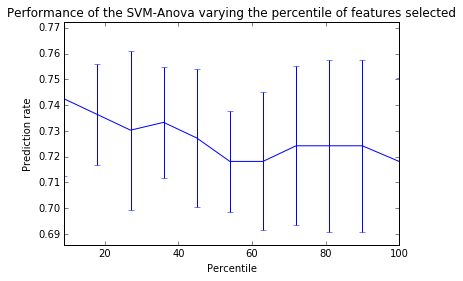

[0.74242424242424254, 0.73636363636363633, 0.73030303030303012, 0.73333333333333339, 0.72727272727272718, 0.71818181818181814, 0.71818181818181814, 0.72424242424242424, 0.72424242424242424, 0.72424242424242424, 0.71818181818181814]


In [35]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svc)])

score_means = list()
score_stds = list()
percentiles = (9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, x_train_all, y_labels, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()
print(score_means)

In [6]:
def evaluate_classifiers(data, labels, svm, gnb, kfold, num_of_iterations=50):
    
    results = {}
    scores_svc_acc, scores_svc_f1, scores_svc_p, scores_svc_r = [], [], [] ,[]
    scores_gnb_acc, scores_gnb_f1, scores_gnb_p, scores_gnb_r = [], [], [] ,[]
    
    for i in np.arange(num_of_iterations):
        cross_val = StratifiedKFold(kfold, shuffle=True)
        scores_svc_acc.extend(cross_val_score(OneVsRestClassifier(svm), data, labels, cv=cross_val, 
                                         scoring='accuracy'))


        scores_svc_f1.extend(cross_val_score(OneVsRestClassifier(svm), data, labels, cv=cross_val, 
                                     scoring='f1'))

        scores_svc_p.extend(cross_val_score(svc, data, labels, cv=cross_val, scoring='precision'))

        scores_svc_r.extend(cross_val_score(OneVsRestClassifier(svm), data, labels, cv=cross_val, 
                                     scoring='recall'))

        scores_gnb_acc.extend(cross_val_score(gnb, data, labels, cv=cross_val, scoring='accuracy'))

        scores_gnb_f1.extend(cross_val_score(gnb, data, labels, cv=cross_val, scoring='f1'))

        scores_gnb_p.extend(cross_val_score(gnb, data, labels, cv=cross_val, scoring='precision'))

        scores_gnb_r.extend(cross_val_score(gnb, data, labels, cv=cross_val, scoring='recall'))
        
    # print("Length scores_svc_acc %d" % len(scores_svc_acc))
    # print("Length scores_svc_f1 %d" % len(scores_svc_f1))
    # print("Length scores_svc_p %d" % len(scores_svc_p))
    # print("Length scores_svc_r %d" % len(scores_svc_r))
    scores_svc_acc = np.array(scores_svc_acc)
    scores_svc_f1 = np.array(scores_svc_f1)
    scores_svc_p = np.array(scores_svc_p)
    scores_svc_r = np.array(scores_svc_r)
    
    scores_gnb_acc = np.array(scores_gnb_acc)
    scores_gnb_f1 = np.array(scores_gnb_f1)
    scores_gnb_p = np.array(scores_gnb_p)
    scores_gnb_r = np.array(scores_gnb_r)
    
    results['svm'] = (scores_svc_acc, scores_svc_f1, scores_svc_p, scores_svc_r)
    results['gnb'] = (scores_gnb_acc, scores_gnb_f1, scores_gnb_p, scores_gnb_r)
    
    # Naive Bayes results
    print("gnb(%d) - Accuracy: %0.3f (+/- %0.2f)" % (data.shape[1], scores_gnb_acc.mean(), 
                                                     scores_gnb_acc.std() * 2))
    print("gnb(%d) - F1: %0.3f (+/- %0.2f)" % (data.shape[1], scores_gnb_f1.mean(), scores_gnb_f1.std() * 2))
    print("gnb(%d) - Precision: %0.3f (+/- %0.2f)" % (data.shape[1], scores_gnb_p.mean(), 
                                                      scores_gnb_p.std() * 2))
    print("gnb(%d) - Recall: %0.3f (+/- %0.2f)" % (data.shape[1], scores_gnb_r.mean(), scores_gnb_r.std() * 2))
    # SVM results
    print("svc(%d) - Accuracy: %0.3f (+/- %0.2f)" % (data.shape[1], scores_svc_acc.mean(), 
                                                     scores_svc_acc.std() * 2))
    print("svc(%d) - F1: %0.3f (+/- %0.2f)" % (data.shape[1], scores_svc_f1.mean(), scores_svc_f1.std() * 2))
    print("svc(%d) - Precision: %0.3f (+/- %0.2f)" % (data.shape[1], scores_svc_p.mean(), scores_svc_p.std() * 2))
    print("svc(%d) - Recall: %0.3f (+/- %0.2f)" % (data.shape[1], scores_svc_r.mean(), scores_svc_r.std() * 2))
    
    return results
    


==================== Two sample T-test between classes 0 <-> 1 ==================
Normal/Positive  210 120
Feature cos_sim: p_value 0.0000 (-0.221/0.387)
--- Final score with k-fold cross-validation
gnb(1) - Accuracy: 0.672 (+/- 0.07)
gnb(1) - F1: 0.357 (+/- 0.18)
gnb(1) - Precision: 0.630 (+/- 0.28)
gnb(1) - Recall: 0.253 (+/- 0.16)
svc(1) - Accuracy: 0.680 (+/- 0.08)
svc(1) - F1: 0.414 (+/- 0.19)
svc(1) - Precision: 0.614 (+/- 0.24)
svc(1) - Recall: 0.328 (+/- 0.18)
Confusion matrix, without normalization
Save to /home/jogi/git/repository/smart_play_set/plots/gnb_classifier_cm_330_2_cos_sim.png


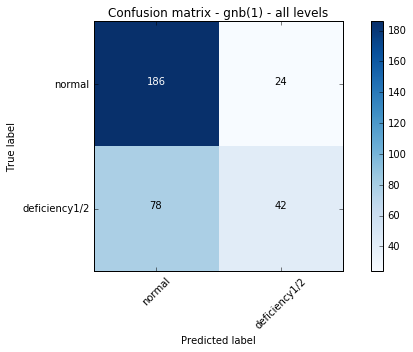

--- Evaluation of classifier per level-dataset
****    Level 1 ****

==================== Two sample T-test between classes 0 <-> 1 ==================
Normal/Positive  70 40
Feature cos_sim: p_value 0.0563 (-0.248/0.158)
gnb(1) - Accuracy: 0.620 (+/- 0.08)
gnb(1) - F1: 0.038 (+/- 0.18)
gnb(1) - Precision: 0.048 (+/- 0.27)
gnb(1) - Recall: 0.018 (+/- 0.11)
svc(1) - Accuracy: 0.656 (+/- 0.15)
svc(1) - F1: 0.340 (+/- 0.37)
svc(1) - Precision: 0.570 (+/- 0.55)
svc(1) - Recall: 0.290 (+/- 0.32)
Confusion matrix, without normalization


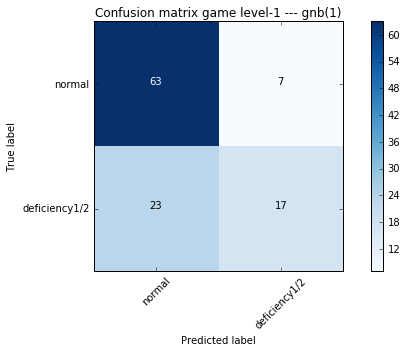

****    Level 2 ****

==================== Two sample T-test between classes 0 <-> 1 ==================
Normal/Positive  70 40
Feature cos_sim: p_value 0.0000 (-0.317/0.595)
gnb(1) - Accuracy: 0.758 (+/- 0.12)
gnb(1) - F1: 0.553 (+/- 0.30)
gnb(1) - Precision: 0.825 (+/- 0.34)
gnb(1) - Recall: 0.439 (+/- 0.35)
svc(1) - Accuracy: 0.742 (+/- 0.12)
svc(1) - F1: 0.488 (+/- 0.34)
svc(1) - Precision: 0.815 (+/- 0.45)
svc(1) - Recall: 0.364 (+/- 0.31)
Confusion matrix, without normalization


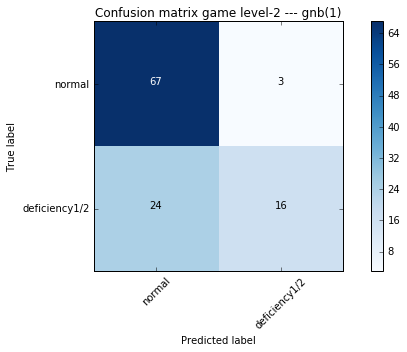

****    Level 3 ****

==================== Two sample T-test between classes 0 <-> 1 ==================
Normal/Positive  70 40
Feature cos_sim: p_value 0.0037 (-0.099/0.409)
gnb(1) - Accuracy: 0.649 (+/- 0.11)
gnb(1) - F1: 0.295 (+/- 0.37)
gnb(1) - Precision: 0.522 (+/- 0.61)
gnb(1) - Recall: 0.242 (+/- 0.32)
svc(1) - Accuracy: 0.670 (+/- 0.15)
svc(1) - F1: 0.386 (+/- 0.32)
svc(1) - Precision: 0.574 (+/- 0.49)
svc(1) - Recall: 0.297 (+/- 0.29)
Confusion matrix, without normalization


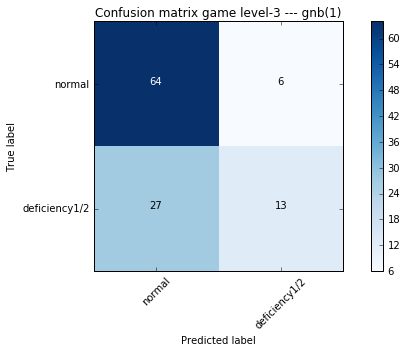

Save to /home/jogi/git/repository/smart_play_set/plots/gnb_classifier_eval_330_2_cos_sim.png
Save to /home/jogi/git/repository/smart_play_set/plots/svm_classifier_eval_330_2_cos_sim.png


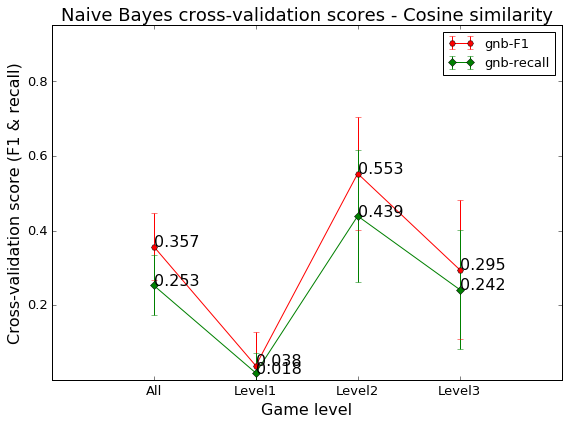

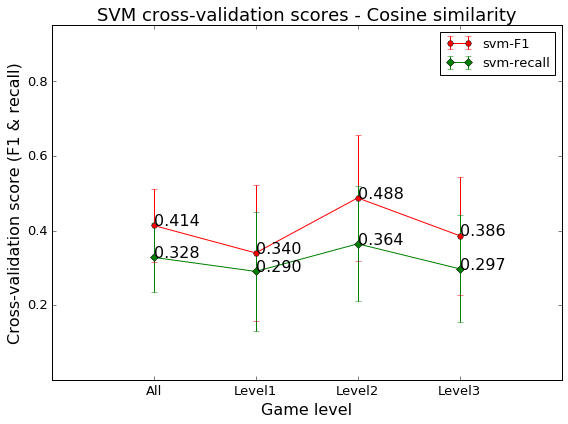

In [10]:
def plot_results(clf, p_title, outfile):
    global results_all_level, res_levels
    
    plt.figure(figsize=(8,6))
    plt.title(p_title, fontsize=18)
    plt.xlim([-1, 4])
    plt.ylim([0., 0.95])
    x_values = np.arange(4)
    x_values_labels = ['All', 'Level1', 'Level2', 'Level3', None]
    plt.xticks(x_values, x_values_labels, fontsize=13)
    plt.yticks([0.2, 0.4, 0.6, 0.8], fontsize=13)
    plt.ylabel("Cross-validation score (F1 & recall)", fontsize=16)
    plt.xlabel("Game level", fontsize=16)
    acc_scores = [results_all_level[clf][0].mean(), res_levels[1][clf][0].mean(), 
                  res_levels[2][clf][0].mean(), res_levels[3][clf][0].mean()]
    acc_err = [results_all_level[clf][0].std(), res_levels[1][clf][0].std(), 
                  res_levels[2][clf][0].std(), res_levels[3][clf][0].std()]
    f1_scores = [results_all_level[clf][1].mean(), res_levels[1][clf][1].mean(), 
                  res_levels[2][clf][1].mean(), res_levels[3][clf][1].mean()]
    f1_err = [results_all_level[clf][1].std(), res_levels[1][clf][1].std(), 
                  res_levels[2][clf][1].std(), res_levels[3][clf][1].std()]
    recall_scores = [results_all_level[clf][3].mean(), res_levels[1][clf][3].mean(), 
                  res_levels[2][clf][3].mean(), res_levels[3][clf][3].mean()]
    recall_err = [results_all_level[clf][3].std(), res_levels[1][clf][3].std(), 
                  res_levels[2][clf][3].std(), res_levels[3][clf][3].std()]
    
    # print("acc-err ", acc_err)
    # print("f1-err ", f1_err)
    plt.errorbar(x_values, f1_scores, yerr=f1_err, marker='H', linestyle='-', c='r', label="%s-F1" % clf)
    
    plt.errorbar(x_values, recall_scores, yerr=recall_err, marker='D', linestyle='-', c='g',
                 label="%s-recall" % clf)
    for a,b in zip(x_values, f1_scores): 
        plt.text(a, b, '{:.3f}'.format(b), fontsize=16)
    for a,b in zip(x_values, recall_scores): 
        plt.text(a, b, '{:.3f}'.format(b), fontsize=16)
    # plt.plot(x_values, recall_scores, 'xg-', label="%s-recall" % clf)

    plt.legend(loc="best", fontsize=13)
    print("Save to %s" % outfile)
    plt.savefig(outfile, dpi=100)

#     0       1             2              3         4              5
# [u'minf', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', 
#                                                      6          7       8        9        10         11
#                                                  u'cos_sim', u'maxf', u'mean', u'std', u'median', u'range']
num_of_games = 55
y_labels = y_labels_2c[:]
# y_labels = y_labels_all
num_of_classes = len(np.unique(y_labels))
num_of_samples = x_train_all.shape[0]
class_labels = "".join([str(int(i)) for i in np.unique(y_labels)])


if num_of_classes == 3:
    data_per_level = level_datasets
    class_names = ["normal", "deficiency 1", "deficiency 2"]
else:
    data_per_level = level_datasets_2c
    class_names = ["normal", "deficiency1/2"]

# feature_list = [2,6,10]
# svc = SVC(kernel="rbf", class_weight='balanced')
svc = SVC(kernel="rbf")
feature_list = [6]
if len(feature_list) == 1:
    feature_string = features[feature_list[0]]
else:
    feature_string = "f" + "_".join([str(i) for i in feature_list])

kfold = 5
# feature_list = [2, 9, 10, 6, 8, 1, 4, 0]   # feature list from ReliefF algo with 2 classes
# [u'mean_squared_jerk', u'std', u'median', u'cos_sim', u'mean', u'rms', u'energy', u'minf']
new_X_all = transform_x(x_train_all, feature_list)

if num_of_classes == 3:
    
    compute_t_test(x_train_all, y_labels, feature_list, features, class_labels=[0,1])
    
    compute_t_test(x_train_all, y_labels, feature_list, features, class_labels=[0,2])
    
    compute_t_test(x_train_all, y_labels, feature_list, features, class_labels=[1,2])
else:
    compute_t_test(x_train_all, y_labels, feature_list, features)

print("--- Final score with k-fold cross-validation")
results_all_level = evaluate_classifiers(new_X_all, y_labels, svc, gnb, kfold)

svc.fit(new_X_all, y_labels)
y_pred = svc.predict(new_X_all)
c_matrix = confusion_matrix(y_labels, y_pred)

plot_title = "Confusion matrix - gnb(%d) - all levels" % new_X_all.shape[1]
outfile = PLOT_OUTPUT_DIR + 'gnb_classifier_cm_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                    "_" + feature_string + '.png'
plot_confusion_matrix(c_matrix, classes=class_names, title=plot_title, outfile=outfile)


print("===================================================================")
print("--- Evaluation of classifier per level-dataset")
res_levels = {}
for key, data in data_per_level.iteritems():
    x_data = data[0]
    y_data = data[1]
    new_X = transform_x(x_data, feature_list)
    print("****    Level %d ****" % key)
    if num_of_classes == 3:
        
        compute_t_test(x_data, y_data, feature_list, features, class_labels=[0,1])
        
        compute_t_test(x_data, y_data, feature_list, features, class_labels=[0,2])
        
        compute_t_test(x_data, y_data, feature_list, features, class_labels=[1,2])
    else:
        compute_t_test(x_data, y_data, feature_list, features)
    
    res_levels[key] = evaluate_classifiers(new_X, y_data, svc, gnb, kfold)
    
    svc.fit(new_X, y_data)
    y_pred = svc.predict(new_X)
    c_matrix = confusion_matrix(y_data, y_pred)
    
    plot_title = "Confusion matrix game level-%d --- gnb(%d)" % (key, new_X.shape[1])
    plot_confusion_matrix(c_matrix, classes=class_names, title=plot_title)


outfile = PLOT_OUTPUT_DIR + 'gnb_classifier_eval_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                    "_" + feature_string + '.png'
if len(feature_list) == 1:
    p_title = "Naive Bayes cross-validation scores - %s" % feature_long_list[feature_list[0]]
else:
    p_title = "Naive Bayes cross-validation scores all features"

plot_results('gnb', p_title, outfile)


if len(feature_list) == 1:
    p_title = "SVM cross-validation scores - %s" % feature_long_list[feature_list[0]]
else:
    p_title = "SVM cross-validation scores all features"
    
outfile = PLOT_OUTPUT_DIR + 'svm_classifier_eval_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + feature_string + '.png'
plot_results('svm', p_title, outfile)

In [ ]:
from sklearn.feature_selection import f_classif

def print_ANOVA_results(F_values, p_values, features):
    
    scores = -np.log10(p_values)
    for i, idx in enumerate(np.argsort(scores)[::-1]):
        print("Feature %s: %.3f F-value %.3f" % (features[idx], scores[idx], F_values[idx]))

print(features)

F_values, p_values = f_classif(new_X_all, y_labels)
print(F_values)
print(p_values)
print_ANOVA_results(F_values, p_values, [2,5,6])

F1 0.562 / Prec 0.529 / Rec 0.600
Confusion matrix, without normalization
Save to /home/jogi/git/repository/smart_play_set/plots/gnb_classifier_cm_330_2_f6.png


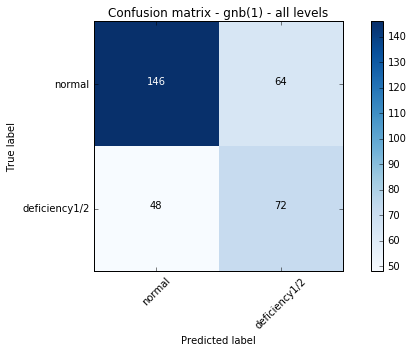

In [63]:
svc = SVC(kernel="rbf", class_weight={0: 0.75, 1: 1.46})
# svc = SVC(kernel="rbf")
svc.fit(new_X_all, y_labels)
y_pred = svc.predict(new_X_all)
c_matrix = confusion_matrix(y_labels, y_pred)
f1 = f1_score(y_labels, y_pred)
pr = precision_score(y_labels, y_pred)
re = recall_score(y_labels, y_pred)
print("F1 %.3f / Prec %.3f / Rec %.3f" % (f1, pr, re))

plot_title = "Confusion matrix - gnb(%d) - all levels" % new_X_all.shape[1]
outfile = PLOT_OUTPUT_DIR + 'gnb_classifier_cm_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                    "_" + feature_string + '.png'
plot_confusion_matrix(c_matrix, classes=class_names, title=plot_title, outfile=outfile)

In [12]:
np.corrcoef(new_X_all.T)

array([[ 1.        ,  0.67162595,  0.52485162,  0.53503654],
       [ 0.67162595,  1.        ,  0.33997756,  0.35868358],
       [ 0.52485162,  0.33997756,  1.        ,  0.99386192],
       [ 0.53503654,  0.35868358,  0.99386192,  1.        ]])

## (3) Feature selection with ReliefF algorithm

    Ranking of features according to evaluation score of algorithm
    Remove feature with the lowest score in each iteration step until we're left with 1 feature
    Test feature set each time with Naive Bayes & SVM by means of cross-fold validation (reporting accuracy and F1 score)
    

======= 12 feature-ranking =======
gnb(12) - Accuracy: 0.706 (+/- 0.259)
gnb(12) - f1: 0.693 (+/- 0.275)
gnb(12) - recall: 0.706 (+/- 0.259)
svc(12) - Accuracy: 0.688 (+/- 0.239)
svc(12) - f1: 0.650 (+/- 0.270)
svc(12) - recall: 0.688 (+/- 0.239)
Ranked features  [u'mean_squared_jerk', u'std', u'power_spec_entropy', u'median', u'rms', u'mean', u'energy', u'cos_sim', u'range', u'dc', u'maxf', u'minf']
Ranked features idx  [2, 9, 5, 10, 1, 8, 4, 6, 11, 3, 7, 0]

==================== Two sample T-test between classes 0 <-> 1 ==================
Normal/Positive  210 120
Feature mean_squared_jerk: p_value 0.0000
Feature std: p_value 0.2116
Feature power_spec_entropy: p_value 0.0008
Feature median: p_value 0.0000
Feature rms: p_value 0.0218
Feature mean: p_value 0.1047
Feature energy: p_value 0.1000
Feature cos_sim: p_value 0.0000
Feature range: p_value 0.3290
Feature dc: p_value 0.2077
Feature maxf: p_value 0.2077
Feature minf: p_value 0.3437
New shape train_data  (330, 11)
======= 11 featur

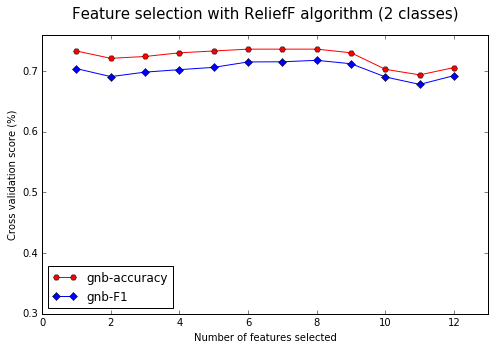

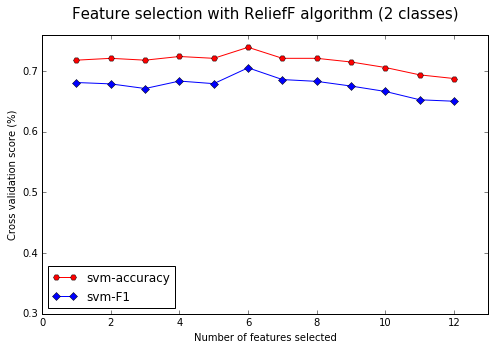

In [10]:
y_labels = y_labels_2c[:]
# y_labels = y_labels_all
# best with 3 classes, 6 features [u'mean_squared_jerk', u'range', u'mean', u'std', u'minf', u'rms']
"""
best with 2 classes:
====================
(1) 8 features
gnb(8) - Accuracy: 0.742 (+/- 0.265)
gnb(8) - f1: 0.602 (+/- 0.412)
svc(8) - Accuracy: 0.718 (+/- 0.197)
svc(8) - f1: 0.471 (+/- 0.401)

mean_squared_jerk 44.2379689568
std 22.2526246915
median 18.7887949492
cos_sim 17.3191976537
mean 15.3754210695
energy 14.7320186932
rms 14.470910009
minf 12.3461975466

or 
(2) 6 features
gnb(6) - Accuracy: 0.745 (+/- 0.243)
gnb(6) - f1: 0.595 (+/- 0.402)
svc(6) - Accuracy: 0.715 (+/- 0.201)
svc(6) - f1: 0.469 (+/- 0.394)

mean_squared_jerk 45.208456643
std 28.1811006354
mean 16.9884122425
median 14.3950405564
cos_sim 12.7935735104
rms 10.8215152881
"""

kept_feature_dict = {}
res_gnb_acc = []
res_gnb_f1 = []
res_gnb_rc = []
res_svc_acc = []
res_svc_f1 = []
res_svc_rc = []

feature_list = [f for f in features]
train_data = np.zeros_like(x_train_all)
train_data[:] = x_train_all[:]
# train_data = level_datasets[1][0]
# y_labels = level_datasets[1][1]

gnb = GaussianNB()
svc = SVC(kernel="rbf", C=1.)
linearSVC = LinearSVC(C=1., penalty="l2", dual=False, loss='squared_hinge')
num_of_times = 25
k = 10
num_of_classes = len(np.unique(y_labels))
num_of_samples = train_data.shape[0]
class_labels = "".join([str(int(i)) for i in np.unique(y_labels)])
feature_list_length = []
    
for f_num in np.arange(len(features)):
    print("======= %d feature-ranking =======" % len(feature_list))
    feature_list_length.append(len(feature_list))
    scores_acc_gnb = cross_val_score(gnb, train_data, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
    scores_acc_svc = cross_val_score(svc, train_data, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
    
    scores_f1_gnb = cross_val_score(gnb, train_data, y_labels, cv=StratifiedKFold(10), scoring='f1_weighted')
    scores_rc_gnb = cross_val_score(gnb, train_data, y_labels, cv=StratifiedKFold(10), scoring='recall_weighted')
    scores_f1_svc = cross_val_score(svc, train_data, y_labels, cv=StratifiedKFold(10), scoring='f1_weighted')
    scores_rc_svc = cross_val_score(svc, train_data, y_labels, cv=StratifiedKFold(10), scoring='recall_weighted')
    
    
    print("gnb(%d) - Accuracy: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_acc_gnb.mean(), 
                                                     scores_acc_gnb.std() * 2))

    print("gnb(%d) - f1: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_f1_gnb.mean(), 
                                               scores_f1_gnb.std() * 2))
    print("gnb(%d) - recall: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_rc_gnb.mean(), 
                                               scores_rc_gnb.std() * 2))
    res_gnb_f1.append(scores_f1_gnb.mean())
    res_gnb_rc.append(scores_rc_gnb.mean())
        
    res_gnb_acc.append(scores_acc_gnb.mean())
        
    print("svc(%d) - Accuracy: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_acc_svc.mean(), 
                                                     scores_acc_svc.std() * 2))

    print("svc(%d) - f1: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_f1_svc.mean(), 
                                               scores_f1_svc.std() * 2))
    print("svc(%d) - recall: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_rc_svc.mean(), 
                                               scores_rc_svc.std() * 2))
    res_svc_f1.append(scores_f1_svc.mean())
    res_svc_rc.append(scores_rc_svc.mean())
        
    res_svc_acc.append(scores_acc_svc.mean())
    final_score = np.zeros(len(feature_list))

    for i in np.arange(num_of_times):
        new_relief_score = reliefF.reliefF(train_data, y_labels, **{"k": k})
        final_score += new_relief_score

    final_score /= num_of_times
    
    new_feature_list = []
    new_feature_idx = []
    for i, idx in enumerate(np.argsort(final_score)[::-1]):
        # print(feature_list[idx], final_score[idx])
        new_feature_list.append(feature_list[idx])
        new_feature_idx.append(idx)
    
    print("Ranked features ", new_feature_list)
    print("Ranked features idx ", new_feature_idx)
    kept_feature_dict[len(new_feature_list)] = new_feature_list
    compute_t_test(train_data, y_labels, new_feature_idx, feature_list)
    
    feature_list = new_feature_list[:-1]
    new_feature_idx = new_feature_idx[:-1]
    train_data = transform_x(train_data, new_feature_idx)
    print("New shape train_data ", train_data.shape)
    
    
# Plot number of features VS. cross-validation scores
markers = ['D', 'H'] # x', '+', '^', 'D', '<', '>', '8', '*', 'H', 'o']
colors = ['b', 'r', 'y']
plt.figure(figsize=(8, 5))
plt.xlim([0, len(features)+1])
plt.ylim([0.30,0.76])
plt.title("Feature selection with ReliefF algorithm (%d classes)" % len(np.unique(y_labels)), fontsize=15, y=1.04)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (%)")
plt.plot(feature_list_length, res_gnb_acc, 'Hr-', label="gnb-accuracy")

plt.plot(feature_list_length, res_gnb_f1, 'Db-', label="gnb-F1")
# plt.plot(feature_list_length, res_gnb_rc, 'xg-', label="gnb-recall")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'gnb_feature_sel_reliefF_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + class_labels + 'classes.png'

print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

plt.figure(figsize=(8, 5))
plt.xlim([0, len(features)+1])
plt.ylim([0.30,0.76])
plt.title("Feature selection with ReliefF algorithm (%d classes)" % len(np.unique(y_labels)), fontsize=15, y=1.04)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (%)")
plt.plot(feature_list_length, res_svc_acc, 'Hr-', label="svm-accuracy")

plt.plot(feature_list_length, res_svc_f1, 'Db-', label="svm-F1")
# plt.plot(feature_list_length, res_svc_rc, 'xg-', label="svm-recall")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'svm_feature_sel_reliefF_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + class_labels + 'classes.png'

print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

In [11]:
x_train_330, y_labels_330, y_labels_2c_330, y_other_330, features = prepare_data(330, two_class_opt='merge_1_2')
x_train_990, y_labels_990, y_labels_2c_990, y_other_990, _ = prepare_data(990, two_class_opt='merge_1_2')
x_train_1980, y_labels_1980, y_labels_2c_1980, y_other_1980, _ = prepare_data(1980, two_class_opt='merge_1_2')


INFO - Used data label 20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True
INFO Loading matrices from h5 file /mnt/disk2/git/repository/smart_play_set/data/futurocube/roadrunner/20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data', u'label_game_level'])
INFO - Loading data description from json.
(210,)
(120,)
Unique labels y_labels_all  [0 1 2]
Unique labels y_labels_2c  [0 1]
Class counts y_labels_all  [210  60  60]
Class counts y_labels_2c  [210 120]
Shape x_train_all  (330, 12)
Shape y_labels_all  (330,)
INFO - Used data label 20161206_futurocube_roadrunner_20hz_1axis_low8hz_990_12_True
INFO Loading matrices from h5 file /mnt/disk2/git/repository/smart_play_set/data/futurocube/roadrunner/20161206_futurocube_roadrunner_20hz_1axis_low8hz_990_12_True.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data', u'label_game_level'])
INFO - Loading data description from json.


In [16]:
def plot_window_effect(clf, p_title, outfile=None):
    global results_330, results_990, results_1980
    
    plt.figure(figsize=(8,6))
    plt.title(p_title)
    plt.xlim([-1, 3])
    plt.ylim([0.15, 0.95])
    x_values = np.arange(3)
    x_values_labels = ['30', '10', '5']
    plt.xticks(x_values, x_values_labels)
    plt.ylabel("Cross-validation score (F1 & recall)", fontsize=16)
    plt.xlabel("Window length (sec)", fontsize=16)
    acc_scores = [results_330[clf][0].mean(), results_990[clf][0].mean(), results_1980[clf][0].mean()]
    acc_err = [results_330[clf][0].std(), results_990[clf][0].std(), results_1980[clf][0].std()]
    
    f1_scores = [results_330[clf][1].mean(), results_990[clf][1].mean(), results_1980[clf][1].mean()]
    f1_err = [results_330[clf][1].std(), results_990[clf][1].std(), results_1980[clf][1].std()]
    
    recall_scores = [results_330[clf][3].mean(), results_990[clf][3].mean(), results_1980[clf][3].mean()]
    recall_err = [results_330[clf][3].std(), results_990[clf][3].std(), results_1980[clf][3].std()]    
    print("f1_scores ", f1_scores)
    print("f1-err ", f1_err)
    plt.errorbar(x_values, f1_scores, yerr=f1_err, marker='H', linestyle='-', c='r', label="%s-F1" % clf)
    plt.errorbar(x_values, recall_scores, yerr=recall_err, marker='D', linestyle='-', c='g',
                 label="%s-recall" % clf)
    for a,b in zip(x_values, f1_scores): 
        plt.text(a, b, '{:.3f}'.format(b), fontsize=16)
    for a,b in zip(x_values, recall_scores): 
        plt.text(a, b, '{:.3f}'.format(b), fontsize=16)
    # plt.plot(x_values, recall_scores, 'xg-', label="%s-recall" % clf)

    plt.legend(loc="best")
    if outfile is not None:
        print("Save to %s" % outfile)
        plt.savefig(outfile, dpi=100)
    plt.show()


In [12]:
gnb = GaussianNB()
svc = SVC(kernel="rbf")

feature_list = [2, 5, 6]
kfold = 5

x_trans_330 = transform_x(x_train_330, feature_list)
x_trans_990 = transform_x(x_train_990, feature_list)
x_trans_1980 = transform_x(x_train_1980, feature_list)

results_330 = evaluate_classifiers(x_trans_330, y_labels_2c_330, svc, gnb, kfold)
results_990 = evaluate_classifiers(x_trans_990, y_labels_2c_990, svc, gnb, kfold)
results_1980 = evaluate_classifiers(x_trans_1980, y_labels_2c_1980, svc, gnb, kfold)

gnb(3) - Accuracy: 0.727 (+/- 0.09)
gnb(3) - F1: 0.546 (+/- 0.16)
gnb(3) - Precision: 0.695 (+/- 0.20)
gnb(3) - Recall: 0.458 (+/- 0.18)
svc(3) - Accuracy: 0.728 (+/- 0.09)
svc(3) - F1: 0.507 (+/- 0.19)
svc(3) - Precision: 0.749 (+/- 0.22)
svc(3) - Recall: 0.389 (+/- 0.20)
gnb(3) - Accuracy: 0.705 (+/- 0.05)
gnb(3) - F1: 0.483 (+/- 0.11)
gnb(3) - Precision: 0.666 (+/- 0.12)
gnb(3) - Recall: 0.383 (+/- 0.10)
svc(3) - Accuracy: 0.697 (+/- 0.04)
svc(3) - F1: 0.401 (+/- 0.10)
svc(3) - Precision: 0.713 (+/- 0.15)
svc(3) - Recall: 0.282 (+/- 0.09)
gnb(3) - Accuracy: 0.687 (+/- 0.03)
gnb(3) - F1: 0.422 (+/- 0.07)
gnb(3) - Precision: 0.643 (+/- 0.11)
gnb(3) - Recall: 0.315 (+/- 0.07)
svc(3) - Accuracy: 0.684 (+/- 0.03)
svc(3) - F1: 0.365 (+/- 0.07)
svc(3) - Precision: 0.681 (+/- 0.11)
svc(3) - Recall: 0.250 (+/- 0.06)


f1_scores  [0.5459369966223383, 0.4829888355181976, 0.42212200829769991]
f1-err  [0.078987644066059265, 0.056735920844325036, 0.033102887278632698]
Save to /home/jogi/git/repository/smart_play_set/plots/gnb_cross_eval_win_length_2_f3.png


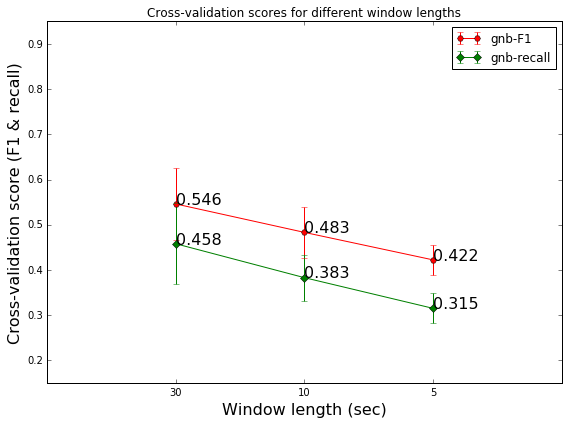

In [18]:
num_of_features = len(feature_list)
outfile = PLOT_OUTPUT_DIR + 'gnb_cross_eval_win_length' + "_" + str(num_of_classes)  + "_f" + \
          str(num_of_features) + ".png"
plot_window_effect('gnb', "Cross-validation scores for different window lengths", outfile)

In [60]:
def plot_mabc_feature_2D(x_data, y_data, scores, col_id, p_title, outfile=None):
    global features, feature_long_list
    
    plt.figure(figsize=(10,6))
    plt.title(p_title, fontsize=16)
    x_values = x_data[:, col_id]
    x_min = np.min(x_values)
    x_max = np.max(x_values)
    x_norm = (x_values - x_min) / float(x_max - x_min)

    y_0 = x_norm[np.where(y_data==0)]
    y_1 = x_norm[np.where(y_data==1)]
    x_0 = scores[np.where(y_data==0)]
    x_1 = scores[np.where(y_data==1)]
    plt.ylabel("Normalized %s value" % feature_long_list[col_id], fontsize=16)
    plt.xlabel("MABC-2 percentile", fontsize=16)
    
    
    plt.scatter(x_0, y_0, marker='H', c='g', label="%s" % "normal")
    plt.scatter(x_1, y_1, marker='D', c='r', label="delayed")

    plt.legend(loc="best")
    if outfile is not None:
        print("Save to %s" % outfile)
        plt.savefig(outfile, dpi=100)
    plt.show()

In [61]:
def mabc_from_ids(ids, mabc_dict):
    
    y_mabc = np.zeros(len(ids))
    for r in np.arange(len(ids)):
        y_mabc[r] = mabc_dict[str(ids[r])]
    
    return y_mabc

mabc_scores = {'6': 25., '35': 37., '13': 50., '38': 84., '37': 0.5, '2': 25., '11' : 5., '7': 84., '36': 63.,
'5': 50., '1': 50., '8': 1., '15': 1., '33': 84., '3': 16., '18': 84., '21': 16., '34': 63., '12': 50., '10': 75.,
'9': 37., '16': 16., '17': 16., '22': 9., '4': 25., '14': 84., '20': 25., '19': 1., '41': 5., '51': 16.}



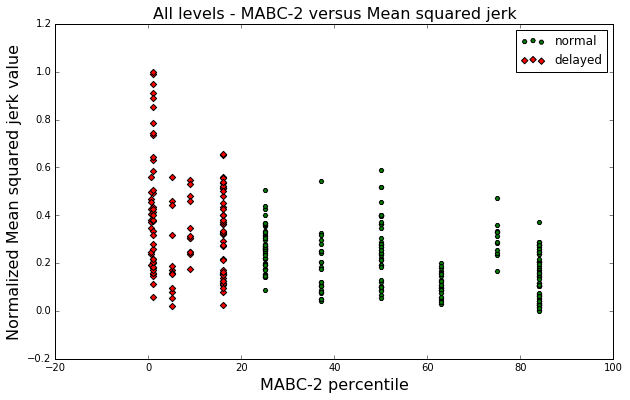

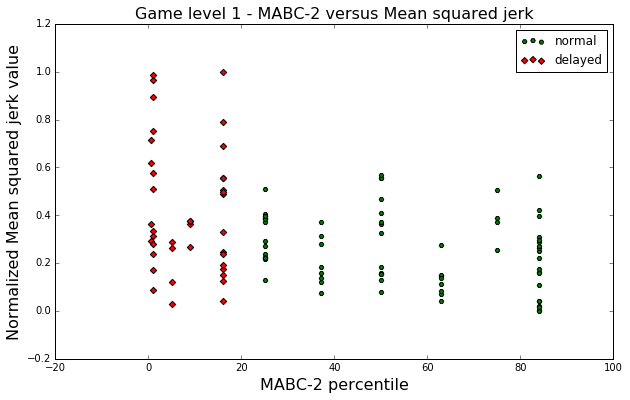

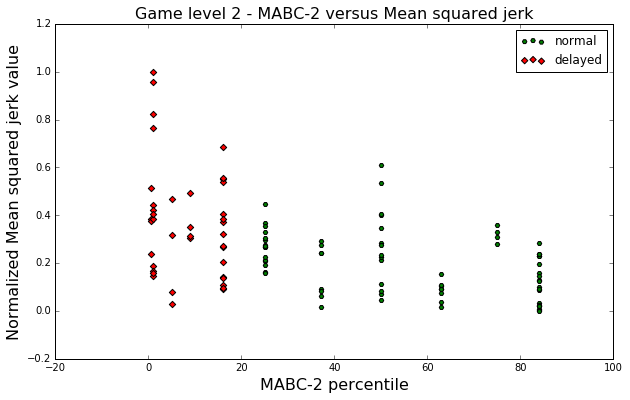

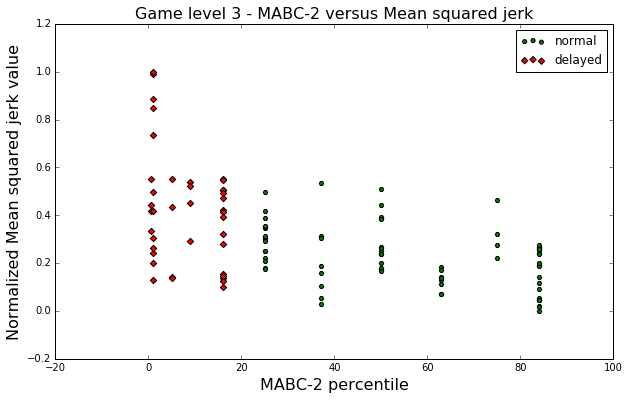

In [62]:
idx = 2
y_mabc_labels_all = mabc_from_ids(y_label_id, mabc_scores)

plot_mabc_feature_2D(x_train_all, y_labels_2c, y_mabc_labels_all, idx, "All levels - MABC-2 versus %s" % 
                     feature_long_list[idx])

for keys, data in level_datasets_2c.iteritems():
    x_data = data[0]
    y_data = data[1]
    y_ids = data[2]
    y_mabc_labels = mabc_from_ids(y_ids, mabc_scores)
    plot_mabc_feature_2D(x_data, y_data, y_mabc_labels, idx, "Game level %d - MABC-2 versus %s" % 
                         (keys, feature_long_list[idx]))